# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [31]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

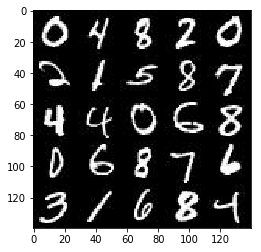

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

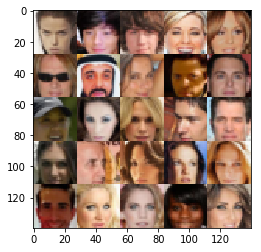

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [34]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [35]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    learning_rate = 0.0002
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_real")
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [36]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128

        x3 = tf.layers.conv2d(relu2, 256, 5, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256
        
        # Conv 4
        x4 = tf.layers.conv2d(relu3, 512, 5, 1, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)

        # Flatten it
        flat = tf.reshape(relu4, (-1, 7*7*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [37]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # First layer is fully connected
        x1 = tf.layers.dense(z, 7*7*512)
        
        # Reshape to start the conv stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 3, strides=1, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 3, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128
        
        x4 = tf.layers.conv2d_transpose(relu3, 64, 3, 2, 'same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(alpha * bn4, bn4)        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 3, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [38]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [39]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    with tf.control_dependencies(g_updates):
        # Optimize
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [40]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [41]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    size = data_shape[1]
    dim = 3 if data_image_mode=="RGB" else 1
       
    input_real, input_z, var_learning_rate = model_inputs(size, size, dim, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, var_learning_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 200
    
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                                
                images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    input_real: images,
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                   })
                _ = sess.run(g_opt, feed_dict={
                    input_z: batch_z,
                    var_learning_rate: learning_rate
                })
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.3f}...".format(train_loss_d),
                          "Generator Loss: {:.3f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, dim, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.979... Generator Loss: 12.299
Epoch 1/2... Discriminator Loss: 4.937... Generator Loss: 0.104
Epoch 1/2... Discriminator Loss: 6.146... Generator Loss: 0.046
Epoch 1/2... Discriminator Loss: 8.351... Generator Loss: 0.001
Epoch 1/2... Discriminator Loss: 5.552... Generator Loss: 0.011
Epoch 1/2... Discriminator Loss: 1.390... Generator Loss: 1.376
Epoch 1/2... Discriminator Loss: 1.805... Generator Loss: 0.646
Epoch 1/2... Discriminator Loss: 1.085... Generator Loss: 1.159
Epoch 1/2... Discriminator Loss: 2.815... Generator Loss: 0.110
Epoch 1/2... Discriminator Loss: 1.026... Generator Loss: 1.255


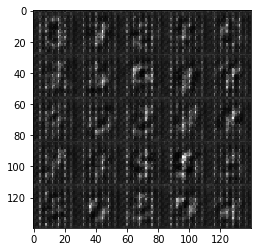

Epoch 1/2... Discriminator Loss: 1.481... Generator Loss: 0.610
Epoch 1/2... Discriminator Loss: 0.955... Generator Loss: 1.589
Epoch 1/2... Discriminator Loss: 1.338... Generator Loss: 0.685
Epoch 1/2... Discriminator Loss: 0.875... Generator Loss: 1.353
Epoch 1/2... Discriminator Loss: 1.764... Generator Loss: 0.342
Epoch 1/2... Discriminator Loss: 0.928... Generator Loss: 2.318
Epoch 1/2... Discriminator Loss: 0.702... Generator Loss: 1.596
Epoch 1/2... Discriminator Loss: 0.676... Generator Loss: 1.655
Epoch 1/2... Discriminator Loss: 1.054... Generator Loss: 0.832
Epoch 1/2... Discriminator Loss: 0.626... Generator Loss: 1.725


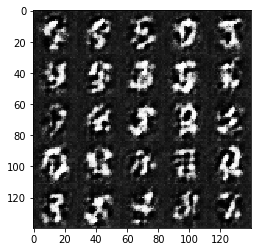

Epoch 1/2... Discriminator Loss: 0.763... Generator Loss: 1.460
Epoch 1/2... Discriminator Loss: 1.941... Generator Loss: 0.379
Epoch 1/2... Discriminator Loss: 1.939... Generator Loss: 0.349
Epoch 1/2... Discriminator Loss: 0.533... Generator Loss: 2.073
Epoch 1/2... Discriminator Loss: 1.309... Generator Loss: 0.818
Epoch 1/2... Discriminator Loss: 1.061... Generator Loss: 1.180
Epoch 1/2... Discriminator Loss: 2.739... Generator Loss: 0.218
Epoch 1/2... Discriminator Loss: 0.776... Generator Loss: 2.861
Epoch 1/2... Discriminator Loss: 1.673... Generator Loss: 0.777
Epoch 1/2... Discriminator Loss: 0.627... Generator Loss: 1.694


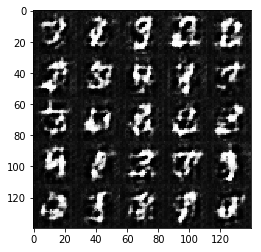

Epoch 1/2... Discriminator Loss: 1.178... Generator Loss: 4.111
Epoch 1/2... Discriminator Loss: 1.023... Generator Loss: 0.844
Epoch 1/2... Discriminator Loss: 0.882... Generator Loss: 1.074
Epoch 1/2... Discriminator Loss: 1.749... Generator Loss: 0.408
Epoch 1/2... Discriminator Loss: 1.090... Generator Loss: 0.874
Epoch 1/2... Discriminator Loss: 2.985... Generator Loss: 0.127
Epoch 1/2... Discriminator Loss: 0.675... Generator Loss: 1.807
Epoch 1/2... Discriminator Loss: 1.288... Generator Loss: 0.744
Epoch 1/2... Discriminator Loss: 2.545... Generator Loss: 0.202
Epoch 1/2... Discriminator Loss: 0.630... Generator Loss: 2.568


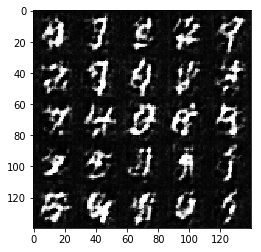

Epoch 1/2... Discriminator Loss: 1.429... Generator Loss: 0.881
Epoch 1/2... Discriminator Loss: 0.698... Generator Loss: 1.866
Epoch 1/2... Discriminator Loss: 0.792... Generator Loss: 1.285
Epoch 1/2... Discriminator Loss: 0.490... Generator Loss: 3.750
Epoch 1/2... Discriminator Loss: 0.511... Generator Loss: 3.658
Epoch 1/2... Discriminator Loss: 1.243... Generator Loss: 0.949
Epoch 1/2... Discriminator Loss: 1.249... Generator Loss: 0.623
Epoch 1/2... Discriminator Loss: 0.764... Generator Loss: 3.176
Epoch 1/2... Discriminator Loss: 1.127... Generator Loss: 1.295
Epoch 1/2... Discriminator Loss: 0.921... Generator Loss: 1.097


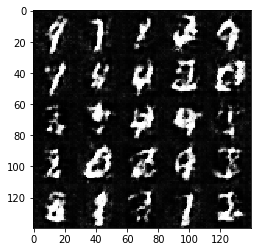

Epoch 1/2... Discriminator Loss: 0.832... Generator Loss: 1.426
Epoch 1/2... Discriminator Loss: 1.561... Generator Loss: 0.529
Epoch 1/2... Discriminator Loss: 2.166... Generator Loss: 0.273
Epoch 1/2... Discriminator Loss: 0.604... Generator Loss: 2.059
Epoch 1/2... Discriminator Loss: 0.455... Generator Loss: 3.029
Epoch 1/2... Discriminator Loss: 1.251... Generator Loss: 0.732
Epoch 1/2... Discriminator Loss: 1.053... Generator Loss: 0.729
Epoch 1/2... Discriminator Loss: 1.378... Generator Loss: 0.528
Epoch 1/2... Discriminator Loss: 2.992... Generator Loss: 0.120
Epoch 1/2... Discriminator Loss: 1.417... Generator Loss: 0.530


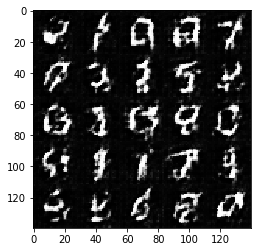

Epoch 1/2... Discriminator Loss: 0.982... Generator Loss: 0.868
Epoch 1/2... Discriminator Loss: 0.913... Generator Loss: 1.045
Epoch 1/2... Discriminator Loss: 0.675... Generator Loss: 1.779
Epoch 1/2... Discriminator Loss: 0.610... Generator Loss: 1.630
Epoch 1/2... Discriminator Loss: 0.791... Generator Loss: 1.291
Epoch 1/2... Discriminator Loss: 1.011... Generator Loss: 1.080
Epoch 1/2... Discriminator Loss: 1.825... Generator Loss: 0.482
Epoch 1/2... Discriminator Loss: 0.932... Generator Loss: 1.081
Epoch 1/2... Discriminator Loss: 1.278... Generator Loss: 0.586
Epoch 1/2... Discriminator Loss: 1.394... Generator Loss: 0.740


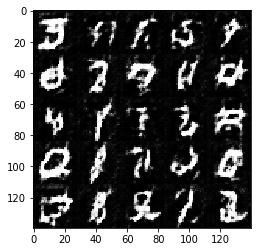

Epoch 1/2... Discriminator Loss: 2.386... Generator Loss: 3.063
Epoch 1/2... Discriminator Loss: 2.912... Generator Loss: 0.121
Epoch 1/2... Discriminator Loss: 0.913... Generator Loss: 1.677
Epoch 1/2... Discriminator Loss: 1.412... Generator Loss: 0.525
Epoch 1/2... Discriminator Loss: 2.833... Generator Loss: 0.113
Epoch 1/2... Discriminator Loss: 0.584... Generator Loss: 2.404
Epoch 1/2... Discriminator Loss: 0.945... Generator Loss: 1.868
Epoch 1/2... Discriminator Loss: 0.857... Generator Loss: 1.827
Epoch 1/2... Discriminator Loss: 2.299... Generator Loss: 0.516
Epoch 1/2... Discriminator Loss: 0.915... Generator Loss: 0.955


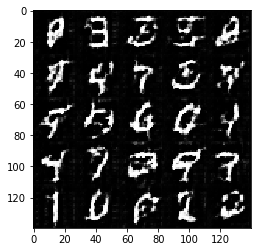

Epoch 1/2... Discriminator Loss: 1.804... Generator Loss: 0.720
Epoch 1/2... Discriminator Loss: 1.983... Generator Loss: 0.288
Epoch 1/2... Discriminator Loss: 1.464... Generator Loss: 0.499
Epoch 1/2... Discriminator Loss: 1.689... Generator Loss: 0.377
Epoch 1/2... Discriminator Loss: 0.551... Generator Loss: 1.951
Epoch 1/2... Discriminator Loss: 1.157... Generator Loss: 0.731
Epoch 1/2... Discriminator Loss: 0.627... Generator Loss: 2.033
Epoch 1/2... Discriminator Loss: 1.178... Generator Loss: 0.694
Epoch 1/2... Discriminator Loss: 0.875... Generator Loss: 1.148
Epoch 1/2... Discriminator Loss: 1.438... Generator Loss: 0.508


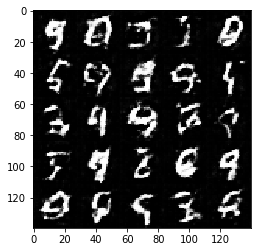

Epoch 1/2... Discriminator Loss: 2.799... Generator Loss: 0.145
Epoch 1/2... Discriminator Loss: 1.871... Generator Loss: 0.507
Epoch 1/2... Discriminator Loss: 0.496... Generator Loss: 2.442
Epoch 1/2... Discriminator Loss: 0.809... Generator Loss: 1.249
Epoch 1/2... Discriminator Loss: 0.777... Generator Loss: 1.558
Epoch 1/2... Discriminator Loss: 1.000... Generator Loss: 0.907
Epoch 1/2... Discriminator Loss: 3.715... Generator Loss: 6.211
Epoch 1/2... Discriminator Loss: 1.836... Generator Loss: 0.349
Epoch 1/2... Discriminator Loss: 1.230... Generator Loss: 0.703
Epoch 1/2... Discriminator Loss: 0.782... Generator Loss: 1.291


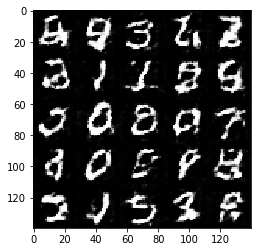

Epoch 1/2... Discriminator Loss: 0.977... Generator Loss: 0.944
Epoch 1/2... Discriminator Loss: 0.776... Generator Loss: 1.715
Epoch 1/2... Discriminator Loss: 0.773... Generator Loss: 1.380
Epoch 1/2... Discriminator Loss: 0.805... Generator Loss: 1.327
Epoch 1/2... Discriminator Loss: 3.145... Generator Loss: 0.136
Epoch 1/2... Discriminator Loss: 1.477... Generator Loss: 1.094
Epoch 1/2... Discriminator Loss: 1.031... Generator Loss: 0.864
Epoch 1/2... Discriminator Loss: 0.619... Generator Loss: 1.961
Epoch 1/2... Discriminator Loss: 3.942... Generator Loss: 0.075
Epoch 1/2... Discriminator Loss: 0.958... Generator Loss: 1.001


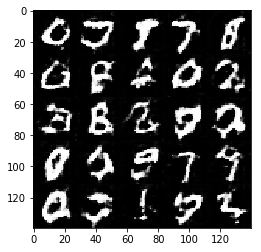

Epoch 1/2... Discriminator Loss: 0.864... Generator Loss: 1.183
Epoch 1/2... Discriminator Loss: 0.643... Generator Loss: 1.759
Epoch 1/2... Discriminator Loss: 1.110... Generator Loss: 2.355
Epoch 1/2... Discriminator Loss: 1.431... Generator Loss: 0.597
Epoch 1/2... Discriminator Loss: 0.930... Generator Loss: 0.952
Epoch 1/2... Discriminator Loss: 2.256... Generator Loss: 0.318
Epoch 1/2... Discriminator Loss: 0.669... Generator Loss: 1.615
Epoch 1/2... Discriminator Loss: 4.412... Generator Loss: 0.042
Epoch 1/2... Discriminator Loss: 1.868... Generator Loss: 0.398
Epoch 1/2... Discriminator Loss: 1.123... Generator Loss: 1.159


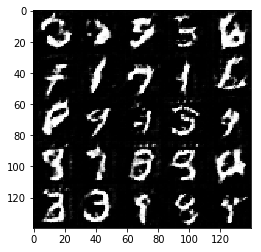

Epoch 1/2... Discriminator Loss: 1.016... Generator Loss: 0.964
Epoch 1/2... Discriminator Loss: 2.572... Generator Loss: 0.254
Epoch 1/2... Discriminator Loss: 0.978... Generator Loss: 0.897
Epoch 1/2... Discriminator Loss: 0.778... Generator Loss: 1.286
Epoch 1/2... Discriminator Loss: 0.727... Generator Loss: 1.561
Epoch 1/2... Discriminator Loss: 1.221... Generator Loss: 0.710
Epoch 1/2... Discriminator Loss: 1.799... Generator Loss: 0.507
Epoch 1/2... Discriminator Loss: 1.048... Generator Loss: 1.008
Epoch 1/2... Discriminator Loss: 0.791... Generator Loss: 1.168
Epoch 1/2... Discriminator Loss: 0.879... Generator Loss: 2.197


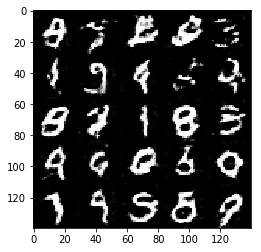

Epoch 1/2... Discriminator Loss: 0.769... Generator Loss: 1.368
Epoch 1/2... Discriminator Loss: 0.692... Generator Loss: 1.421
Epoch 1/2... Discriminator Loss: 1.520... Generator Loss: 0.582
Epoch 1/2... Discriminator Loss: 1.460... Generator Loss: 0.507
Epoch 1/2... Discriminator Loss: 0.813... Generator Loss: 1.408
Epoch 1/2... Discriminator Loss: 1.043... Generator Loss: 0.904
Epoch 1/2... Discriminator Loss: 0.648... Generator Loss: 1.808
Epoch 1/2... Discriminator Loss: 1.679... Generator Loss: 0.374
Epoch 1/2... Discriminator Loss: 1.810... Generator Loss: 0.362
Epoch 1/2... Discriminator Loss: 0.511... Generator Loss: 2.194


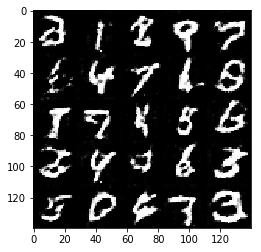

Epoch 1/2... Discriminator Loss: 1.314... Generator Loss: 0.841
Epoch 1/2... Discriminator Loss: 0.860... Generator Loss: 1.205
Epoch 1/2... Discriminator Loss: 0.994... Generator Loss: 1.413
Epoch 1/2... Discriminator Loss: 1.573... Generator Loss: 0.549
Epoch 1/2... Discriminator Loss: 0.567... Generator Loss: 1.852
Epoch 1/2... Discriminator Loss: 0.959... Generator Loss: 1.046
Epoch 1/2... Discriminator Loss: 1.133... Generator Loss: 1.024
Epoch 1/2... Discriminator Loss: 1.216... Generator Loss: 1.243
Epoch 1/2... Discriminator Loss: 1.204... Generator Loss: 0.726
Epoch 1/2... Discriminator Loss: 0.621... Generator Loss: 2.408


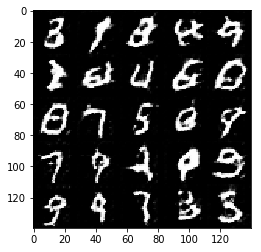

Epoch 1/2... Discriminator Loss: 1.408... Generator Loss: 0.706
Epoch 1/2... Discriminator Loss: 0.637... Generator Loss: 1.976
Epoch 1/2... Discriminator Loss: 0.902... Generator Loss: 0.984
Epoch 1/2... Discriminator Loss: 1.528... Generator Loss: 0.450
Epoch 1/2... Discriminator Loss: 1.854... Generator Loss: 0.383
Epoch 1/2... Discriminator Loss: 1.074... Generator Loss: 1.023
Epoch 1/2... Discriminator Loss: 0.545... Generator Loss: 2.082
Epoch 1/2... Discriminator Loss: 1.045... Generator Loss: 0.961
Epoch 1/2... Discriminator Loss: 0.877... Generator Loss: 1.039
Epoch 1/2... Discriminator Loss: 1.194... Generator Loss: 1.037


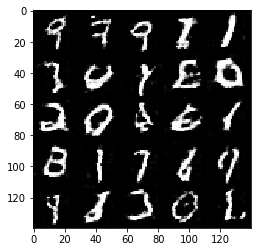

Epoch 1/2... Discriminator Loss: 2.874... Generator Loss: 0.182
Epoch 1/2... Discriminator Loss: 0.742... Generator Loss: 1.352
Epoch 1/2... Discriminator Loss: 1.201... Generator Loss: 0.910
Epoch 1/2... Discriminator Loss: 0.967... Generator Loss: 1.362
Epoch 1/2... Discriminator Loss: 2.221... Generator Loss: 0.281
Epoch 1/2... Discriminator Loss: 0.773... Generator Loss: 1.408
Epoch 1/2... Discriminator Loss: 1.166... Generator Loss: 0.654
Epoch 1/2... Discriminator Loss: 1.024... Generator Loss: 1.075
Epoch 1/2... Discriminator Loss: 0.936... Generator Loss: 1.005
Epoch 1/2... Discriminator Loss: 0.690... Generator Loss: 2.111


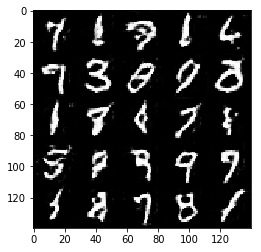

Epoch 1/2... Discriminator Loss: 1.838... Generator Loss: 0.313
Epoch 1/2... Discriminator Loss: 0.968... Generator Loss: 0.958
Epoch 1/2... Discriminator Loss: 1.072... Generator Loss: 0.891
Epoch 1/2... Discriminator Loss: 1.299... Generator Loss: 0.669
Epoch 1/2... Discriminator Loss: 0.615... Generator Loss: 1.899
Epoch 1/2... Discriminator Loss: 1.207... Generator Loss: 0.715
Epoch 1/2... Discriminator Loss: 1.674... Generator Loss: 0.519
Epoch 1/2... Discriminator Loss: 0.622... Generator Loss: 2.114
Epoch 1/2... Discriminator Loss: 0.762... Generator Loss: 2.752
Epoch 1/2... Discriminator Loss: 0.818... Generator Loss: 1.257


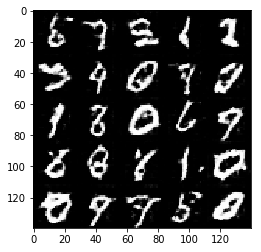

Epoch 1/2... Discriminator Loss: 0.780... Generator Loss: 2.803
Epoch 1/2... Discriminator Loss: 0.633... Generator Loss: 2.815
Epoch 1/2... Discriminator Loss: 1.097... Generator Loss: 1.987
Epoch 1/2... Discriminator Loss: 1.031... Generator Loss: 0.887
Epoch 1/2... Discriminator Loss: 0.734... Generator Loss: 1.464
Epoch 1/2... Discriminator Loss: 0.582... Generator Loss: 2.075
Epoch 1/2... Discriminator Loss: 1.032... Generator Loss: 0.920
Epoch 1/2... Discriminator Loss: 1.414... Generator Loss: 0.572
Epoch 1/2... Discriminator Loss: 1.185... Generator Loss: 0.820
Epoch 1/2... Discriminator Loss: 1.362... Generator Loss: 0.690


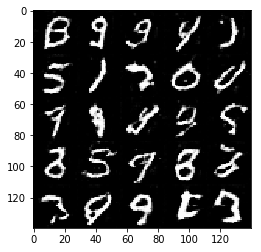

Epoch 1/2... Discriminator Loss: 0.848... Generator Loss: 1.469
Epoch 1/2... Discriminator Loss: 0.533... Generator Loss: 2.276
Epoch 1/2... Discriminator Loss: 1.084... Generator Loss: 0.945
Epoch 1/2... Discriminator Loss: 1.397... Generator Loss: 0.522
Epoch 1/2... Discriminator Loss: 1.375... Generator Loss: 0.634
Epoch 1/2... Discriminator Loss: 1.072... Generator Loss: 0.960
Epoch 1/2... Discriminator Loss: 0.416... Generator Loss: 2.984
Epoch 1/2... Discriminator Loss: 1.176... Generator Loss: 0.735
Epoch 1/2... Discriminator Loss: 0.722... Generator Loss: 1.340
Epoch 1/2... Discriminator Loss: 1.158... Generator Loss: 0.820


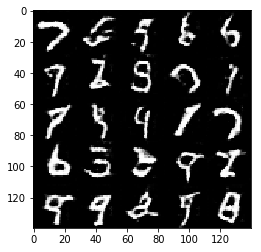

Epoch 1/2... Discriminator Loss: 1.352... Generator Loss: 0.593
Epoch 1/2... Discriminator Loss: 1.876... Generator Loss: 0.393
Epoch 1/2... Discriminator Loss: 0.765... Generator Loss: 1.304
Epoch 1/2... Discriminator Loss: 1.034... Generator Loss: 0.928
Epoch 1/2... Discriminator Loss: 0.711... Generator Loss: 1.325
Epoch 1/2... Discriminator Loss: 1.845... Generator Loss: 0.472
Epoch 1/2... Discriminator Loss: 2.333... Generator Loss: 0.319
Epoch 1/2... Discriminator Loss: 1.165... Generator Loss: 0.851
Epoch 1/2... Discriminator Loss: 0.554... Generator Loss: 1.985
Epoch 1/2... Discriminator Loss: 0.614... Generator Loss: 1.744


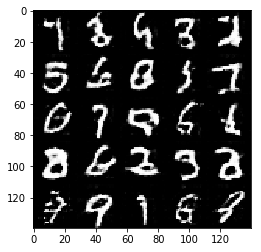

Epoch 1/2... Discriminator Loss: 1.341... Generator Loss: 0.686
Epoch 1/2... Discriminator Loss: 0.772... Generator Loss: 1.410
Epoch 1/2... Discriminator Loss: 0.533... Generator Loss: 2.206
Epoch 1/2... Discriminator Loss: 0.768... Generator Loss: 1.194
Epoch 1/2... Discriminator Loss: 0.808... Generator Loss: 1.054
Epoch 1/2... Discriminator Loss: 0.753... Generator Loss: 1.566
Epoch 1/2... Discriminator Loss: 0.724... Generator Loss: 1.786
Epoch 1/2... Discriminator Loss: 0.819... Generator Loss: 1.446
Epoch 1/2... Discriminator Loss: 2.011... Generator Loss: 0.362
Epoch 1/2... Discriminator Loss: 0.767... Generator Loss: 2.841


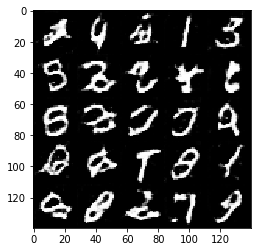

Epoch 1/2... Discriminator Loss: 0.601... Generator Loss: 1.636
Epoch 1/2... Discriminator Loss: 1.731... Generator Loss: 0.480
Epoch 1/2... Discriminator Loss: 2.361... Generator Loss: 0.269
Epoch 1/2... Discriminator Loss: 1.106... Generator Loss: 0.737
Epoch 1/2... Discriminator Loss: 0.554... Generator Loss: 2.101
Epoch 1/2... Discriminator Loss: 1.324... Generator Loss: 1.080
Epoch 1/2... Discriminator Loss: 0.836... Generator Loss: 1.247
Epoch 1/2... Discriminator Loss: 0.767... Generator Loss: 2.058
Epoch 1/2... Discriminator Loss: 1.596... Generator Loss: 0.469
Epoch 1/2... Discriminator Loss: 1.295... Generator Loss: 1.101


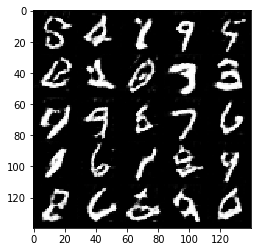

Epoch 1/2... Discriminator Loss: 0.915... Generator Loss: 1.335
Epoch 1/2... Discriminator Loss: 1.053... Generator Loss: 1.022
Epoch 1/2... Discriminator Loss: 0.620... Generator Loss: 1.733
Epoch 1/2... Discriminator Loss: 2.246... Generator Loss: 0.257
Epoch 1/2... Discriminator Loss: 0.505... Generator Loss: 2.115
Epoch 1/2... Discriminator Loss: 0.687... Generator Loss: 1.474
Epoch 1/2... Discriminator Loss: 0.577... Generator Loss: 1.874
Epoch 1/2... Discriminator Loss: 1.375... Generator Loss: 0.465
Epoch 1/2... Discriminator Loss: 1.217... Generator Loss: 0.764
Epoch 1/2... Discriminator Loss: 0.554... Generator Loss: 2.023


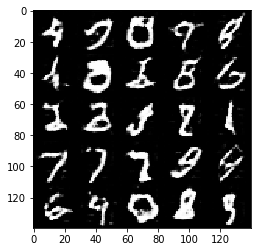

Epoch 1/2... Discriminator Loss: 0.530... Generator Loss: 2.300
Epoch 1/2... Discriminator Loss: 1.046... Generator Loss: 0.878
Epoch 1/2... Discriminator Loss: 0.994... Generator Loss: 0.934
Epoch 1/2... Discriminator Loss: 1.177... Generator Loss: 1.315
Epoch 1/2... Discriminator Loss: 0.731... Generator Loss: 1.495
Epoch 1/2... Discriminator Loss: 0.674... Generator Loss: 1.492
Epoch 1/2... Discriminator Loss: 1.014... Generator Loss: 1.264
Epoch 1/2... Discriminator Loss: 1.427... Generator Loss: 0.776
Epoch 1/2... Discriminator Loss: 0.691... Generator Loss: 1.694
Epoch 1/2... Discriminator Loss: 1.125... Generator Loss: 0.805


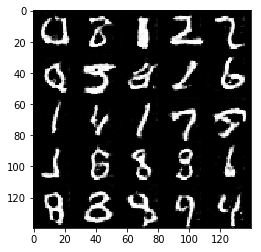

Epoch 1/2... Discriminator Loss: 0.933... Generator Loss: 1.057
Epoch 1/2... Discriminator Loss: 0.778... Generator Loss: 2.793
Epoch 1/2... Discriminator Loss: 1.923... Generator Loss: 0.318
Epoch 1/2... Discriminator Loss: 0.918... Generator Loss: 0.967
Epoch 1/2... Discriminator Loss: 0.713... Generator Loss: 2.177
Epoch 1/2... Discriminator Loss: 0.841... Generator Loss: 1.130
Epoch 1/2... Discriminator Loss: 2.003... Generator Loss: 0.299
Epoch 1/2... Discriminator Loss: 0.651... Generator Loss: 2.744
Epoch 1/2... Discriminator Loss: 1.393... Generator Loss: 3.906
Epoch 1/2... Discriminator Loss: 0.764... Generator Loss: 1.444


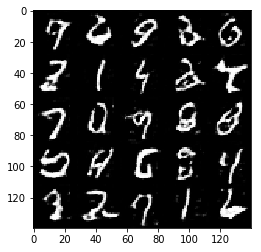

Epoch 1/2... Discriminator Loss: 1.730... Generator Loss: 0.419
Epoch 1/2... Discriminator Loss: 0.480... Generator Loss: 3.273
Epoch 1/2... Discriminator Loss: 0.931... Generator Loss: 1.268
Epoch 1/2... Discriminator Loss: 0.662... Generator Loss: 1.513
Epoch 1/2... Discriminator Loss: 1.289... Generator Loss: 0.830
Epoch 1/2... Discriminator Loss: 1.088... Generator Loss: 3.072
Epoch 1/2... Discriminator Loss: 1.294... Generator Loss: 0.622
Epoch 1/2... Discriminator Loss: 0.877... Generator Loss: 1.134
Epoch 1/2... Discriminator Loss: 2.166... Generator Loss: 0.502
Epoch 1/2... Discriminator Loss: 0.845... Generator Loss: 1.221


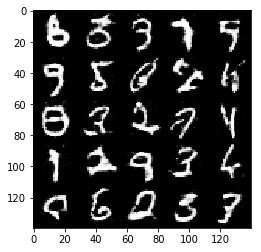

Epoch 1/2... Discriminator Loss: 1.511... Generator Loss: 0.508
Epoch 1/2... Discriminator Loss: 1.486... Generator Loss: 0.479
Epoch 1/2... Discriminator Loss: 2.534... Generator Loss: 0.182
Epoch 1/2... Discriminator Loss: 0.528... Generator Loss: 2.297
Epoch 1/2... Discriminator Loss: 2.136... Generator Loss: 0.376
Epoch 1/2... Discriminator Loss: 1.062... Generator Loss: 0.861
Epoch 1/2... Discriminator Loss: 0.961... Generator Loss: 1.687
Epoch 1/2... Discriminator Loss: 0.481... Generator Loss: 4.386
Epoch 1/2... Discriminator Loss: 1.084... Generator Loss: 0.702
Epoch 1/2... Discriminator Loss: 0.568... Generator Loss: 2.620


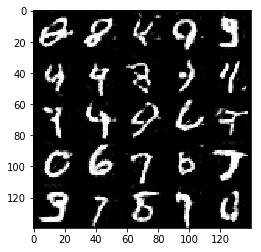

Epoch 1/2... Discriminator Loss: 0.725... Generator Loss: 2.968
Epoch 1/2... Discriminator Loss: 0.784... Generator Loss: 1.546
Epoch 1/2... Discriminator Loss: 0.682... Generator Loss: 1.775
Epoch 1/2... Discriminator Loss: 1.212... Generator Loss: 0.693
Epoch 1/2... Discriminator Loss: 1.340... Generator Loss: 1.005
Epoch 1/2... Discriminator Loss: 1.289... Generator Loss: 0.898
Epoch 1/2... Discriminator Loss: 1.178... Generator Loss: 0.889
Epoch 1/2... Discriminator Loss: 1.284... Generator Loss: 0.635
Epoch 1/2... Discriminator Loss: 0.762... Generator Loss: 1.634
Epoch 1/2... Discriminator Loss: 0.796... Generator Loss: 1.161


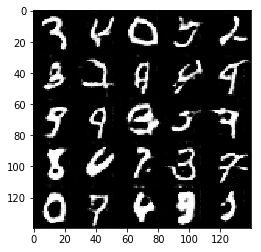

Epoch 1/2... Discriminator Loss: 0.671... Generator Loss: 1.920
Epoch 1/2... Discriminator Loss: 1.353... Generator Loss: 0.590
Epoch 1/2... Discriminator Loss: 0.808... Generator Loss: 1.225
Epoch 1/2... Discriminator Loss: 1.131... Generator Loss: 0.908
Epoch 1/2... Discriminator Loss: 0.819... Generator Loss: 1.328
Epoch 1/2... Discriminator Loss: 1.035... Generator Loss: 0.881
Epoch 1/2... Discriminator Loss: 0.692... Generator Loss: 1.701
Epoch 1/2... Discriminator Loss: 1.282... Generator Loss: 0.965
Epoch 1/2... Discriminator Loss: 1.106... Generator Loss: 0.990
Epoch 1/2... Discriminator Loss: 0.592... Generator Loss: 2.379


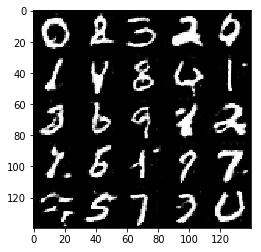

Epoch 2/2... Discriminator Loss: 0.598... Generator Loss: 1.853
Epoch 2/2... Discriminator Loss: 0.672... Generator Loss: 3.510
Epoch 2/2... Discriminator Loss: 0.758... Generator Loss: 1.267
Epoch 2/2... Discriminator Loss: 0.613... Generator Loss: 2.094
Epoch 2/2... Discriminator Loss: 1.435... Generator Loss: 0.478
Epoch 2/2... Discriminator Loss: 0.988... Generator Loss: 0.769
Epoch 2/2... Discriminator Loss: 1.214... Generator Loss: 0.761
Epoch 2/2... Discriminator Loss: 1.419... Generator Loss: 0.816
Epoch 2/2... Discriminator Loss: 0.666... Generator Loss: 1.591
Epoch 2/2... Discriminator Loss: 1.469... Generator Loss: 0.550


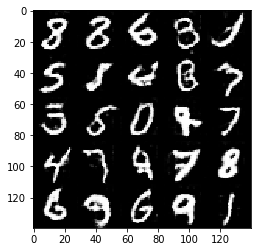

Epoch 2/2... Discriminator Loss: 0.767... Generator Loss: 1.291
Epoch 2/2... Discriminator Loss: 1.056... Generator Loss: 0.887
Epoch 2/2... Discriminator Loss: 1.264... Generator Loss: 0.606
Epoch 2/2... Discriminator Loss: 0.778... Generator Loss: 1.252
Epoch 2/2... Discriminator Loss: 1.074... Generator Loss: 0.920
Epoch 2/2... Discriminator Loss: 0.830... Generator Loss: 1.142
Epoch 2/2... Discriminator Loss: 0.661... Generator Loss: 2.052
Epoch 2/2... Discriminator Loss: 0.582... Generator Loss: 1.996
Epoch 2/2... Discriminator Loss: 0.425... Generator Loss: 2.790
Epoch 2/2... Discriminator Loss: 0.527... Generator Loss: 2.668


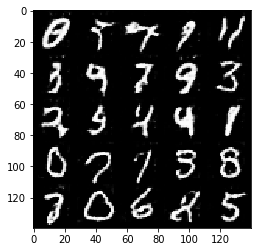

Epoch 2/2... Discriminator Loss: 0.801... Generator Loss: 1.206
Epoch 2/2... Discriminator Loss: 0.976... Generator Loss: 0.931
Epoch 2/2... Discriminator Loss: 0.802... Generator Loss: 1.111
Epoch 2/2... Discriminator Loss: 1.363... Generator Loss: 0.836
Epoch 2/2... Discriminator Loss: 1.014... Generator Loss: 5.034
Epoch 2/2... Discriminator Loss: 0.753... Generator Loss: 1.632
Epoch 2/2... Discriminator Loss: 1.745... Generator Loss: 0.438
Epoch 2/2... Discriminator Loss: 0.832... Generator Loss: 2.721
Epoch 2/2... Discriminator Loss: 1.207... Generator Loss: 0.686
Epoch 2/2... Discriminator Loss: 0.974... Generator Loss: 0.958


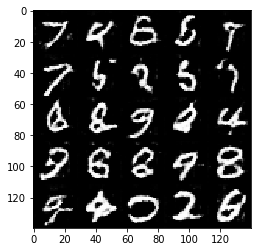

Epoch 2/2... Discriminator Loss: 0.591... Generator Loss: 2.552
Epoch 2/2... Discriminator Loss: 1.163... Generator Loss: 0.785
Epoch 2/2... Discriminator Loss: 1.188... Generator Loss: 0.670
Epoch 2/2... Discriminator Loss: 1.712... Generator Loss: 0.373
Epoch 2/2... Discriminator Loss: 0.853... Generator Loss: 1.261
Epoch 2/2... Discriminator Loss: 0.576... Generator Loss: 2.102
Epoch 2/2... Discriminator Loss: 0.851... Generator Loss: 1.063
Epoch 2/2... Discriminator Loss: 1.352... Generator Loss: 0.590
Epoch 2/2... Discriminator Loss: 0.612... Generator Loss: 1.583
Epoch 2/2... Discriminator Loss: 0.881... Generator Loss: 1.571


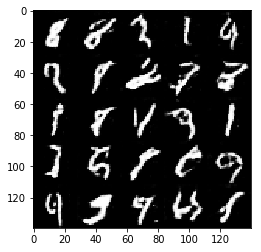

Epoch 2/2... Discriminator Loss: 0.606... Generator Loss: 1.841
Epoch 2/2... Discriminator Loss: 1.191... Generator Loss: 0.781
Epoch 2/2... Discriminator Loss: 0.605... Generator Loss: 1.553
Epoch 2/2... Discriminator Loss: 1.139... Generator Loss: 0.710
Epoch 2/2... Discriminator Loss: 0.600... Generator Loss: 1.929
Epoch 2/2... Discriminator Loss: 0.626... Generator Loss: 1.700
Epoch 2/2... Discriminator Loss: 0.911... Generator Loss: 1.188
Epoch 2/2... Discriminator Loss: 0.877... Generator Loss: 2.123
Epoch 2/2... Discriminator Loss: 0.655... Generator Loss: 2.261
Epoch 2/2... Discriminator Loss: 0.523... Generator Loss: 2.124


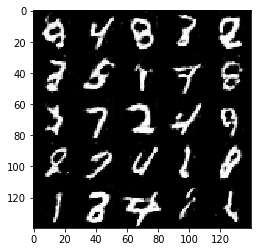

Epoch 2/2... Discriminator Loss: 0.508... Generator Loss: 2.799
Epoch 2/2... Discriminator Loss: 0.501... Generator Loss: 2.072
Epoch 2/2... Discriminator Loss: 1.716... Generator Loss: 0.555
Epoch 2/2... Discriminator Loss: 0.757... Generator Loss: 1.365
Epoch 2/2... Discriminator Loss: 1.062... Generator Loss: 0.737
Epoch 2/2... Discriminator Loss: 1.898... Generator Loss: 0.324
Epoch 2/2... Discriminator Loss: 0.577... Generator Loss: 2.109
Epoch 2/2... Discriminator Loss: 1.182... Generator Loss: 0.801
Epoch 2/2... Discriminator Loss: 1.634... Generator Loss: 0.557
Epoch 2/2... Discriminator Loss: 2.034... Generator Loss: 0.301


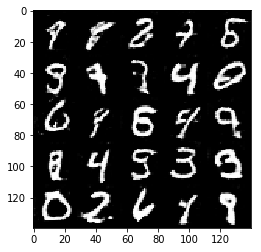

Epoch 2/2... Discriminator Loss: 0.836... Generator Loss: 1.273
Epoch 2/2... Discriminator Loss: 1.056... Generator Loss: 0.943
Epoch 2/2... Discriminator Loss: 1.398... Generator Loss: 0.646
Epoch 2/2... Discriminator Loss: 0.914... Generator Loss: 1.135
Epoch 2/2... Discriminator Loss: 0.837... Generator Loss: 1.178
Epoch 2/2... Discriminator Loss: 1.194... Generator Loss: 0.702
Epoch 2/2... Discriminator Loss: 1.201... Generator Loss: 0.687
Epoch 2/2... Discriminator Loss: 1.025... Generator Loss: 0.867
Epoch 2/2... Discriminator Loss: 2.169... Generator Loss: 0.342
Epoch 2/2... Discriminator Loss: 0.667... Generator Loss: 1.431


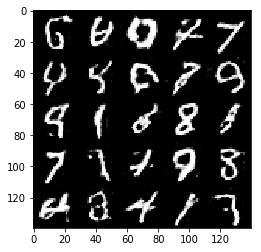

Epoch 2/2... Discriminator Loss: 0.749... Generator Loss: 2.666
Epoch 2/2... Discriminator Loss: 1.953... Generator Loss: 0.317
Epoch 2/2... Discriminator Loss: 0.740... Generator Loss: 1.633
Epoch 2/2... Discriminator Loss: 0.593... Generator Loss: 2.311
Epoch 2/2... Discriminator Loss: 1.668... Generator Loss: 0.455
Epoch 2/2... Discriminator Loss: 0.849... Generator Loss: 1.239
Epoch 2/2... Discriminator Loss: 1.191... Generator Loss: 0.700
Epoch 2/2... Discriminator Loss: 0.728... Generator Loss: 1.251
Epoch 2/2... Discriminator Loss: 0.781... Generator Loss: 1.156
Epoch 2/2... Discriminator Loss: 0.627... Generator Loss: 1.951


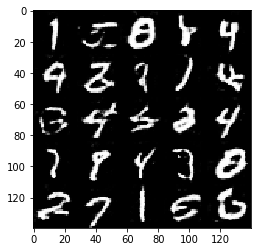

Epoch 2/2... Discriminator Loss: 1.181... Generator Loss: 1.388
Epoch 2/2... Discriminator Loss: 0.777... Generator Loss: 1.460
Epoch 2/2... Discriminator Loss: 2.138... Generator Loss: 0.277
Epoch 2/2... Discriminator Loss: 0.641... Generator Loss: 2.548
Epoch 2/2... Discriminator Loss: 1.022... Generator Loss: 1.476
Epoch 2/2... Discriminator Loss: 0.873... Generator Loss: 1.026
Epoch 2/2... Discriminator Loss: 0.456... Generator Loss: 2.779
Epoch 2/2... Discriminator Loss: 0.950... Generator Loss: 1.948
Epoch 2/2... Discriminator Loss: 1.487... Generator Loss: 0.532
Epoch 2/2... Discriminator Loss: 0.816... Generator Loss: 1.082


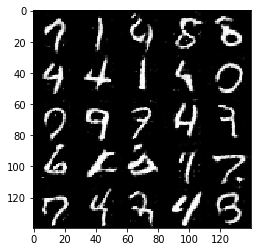

Epoch 2/2... Discriminator Loss: 1.425... Generator Loss: 0.483
Epoch 2/2... Discriminator Loss: 1.172... Generator Loss: 0.820
Epoch 2/2... Discriminator Loss: 1.066... Generator Loss: 0.813
Epoch 2/2... Discriminator Loss: 1.026... Generator Loss: 0.918
Epoch 2/2... Discriminator Loss: 0.824... Generator Loss: 3.743
Epoch 2/2... Discriminator Loss: 1.373... Generator Loss: 0.706
Epoch 2/2... Discriminator Loss: 0.705... Generator Loss: 2.266
Epoch 2/2... Discriminator Loss: 1.039... Generator Loss: 1.067
Epoch 2/2... Discriminator Loss: 0.765... Generator Loss: 1.530
Epoch 2/2... Discriminator Loss: 1.152... Generator Loss: 0.674


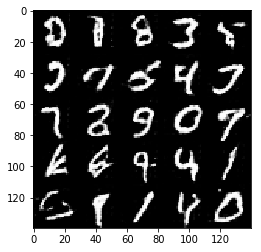

Epoch 2/2... Discriminator Loss: 1.056... Generator Loss: 1.028
Epoch 2/2... Discriminator Loss: 0.612... Generator Loss: 1.913
Epoch 2/2... Discriminator Loss: 0.593... Generator Loss: 1.978
Epoch 2/2... Discriminator Loss: 0.543... Generator Loss: 2.038
Epoch 2/2... Discriminator Loss: 0.471... Generator Loss: 2.639
Epoch 2/2... Discriminator Loss: 1.890... Generator Loss: 0.311
Epoch 2/2... Discriminator Loss: 1.319... Generator Loss: 4.191
Epoch 2/2... Discriminator Loss: 1.026... Generator Loss: 1.139
Epoch 2/2... Discriminator Loss: 0.471... Generator Loss: 2.447
Epoch 2/2... Discriminator Loss: 0.789... Generator Loss: 1.277


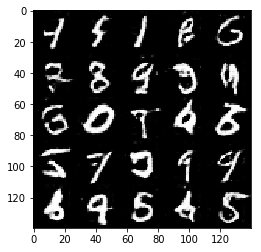

Epoch 2/2... Discriminator Loss: 1.165... Generator Loss: 1.164
Epoch 2/2... Discriminator Loss: 0.558... Generator Loss: 1.998
Epoch 2/2... Discriminator Loss: 0.769... Generator Loss: 1.226
Epoch 2/2... Discriminator Loss: 1.654... Generator Loss: 0.695
Epoch 2/2... Discriminator Loss: 0.550... Generator Loss: 1.962
Epoch 2/2... Discriminator Loss: 1.098... Generator Loss: 0.838
Epoch 2/2... Discriminator Loss: 0.873... Generator Loss: 1.485
Epoch 2/2... Discriminator Loss: 2.375... Generator Loss: 0.272
Epoch 2/2... Discriminator Loss: 0.595... Generator Loss: 1.647
Epoch 2/2... Discriminator Loss: 0.924... Generator Loss: 2.807


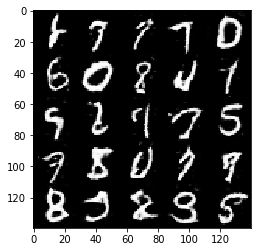

Epoch 2/2... Discriminator Loss: 0.560... Generator Loss: 5.100
Epoch 2/2... Discriminator Loss: 0.724... Generator Loss: 1.440
Epoch 2/2... Discriminator Loss: 0.774... Generator Loss: 1.276
Epoch 2/2... Discriminator Loss: 0.754... Generator Loss: 1.401
Epoch 2/2... Discriminator Loss: 0.636... Generator Loss: 1.658
Epoch 2/2... Discriminator Loss: 0.746... Generator Loss: 1.326
Epoch 2/2... Discriminator Loss: 1.277... Generator Loss: 0.666
Epoch 2/2... Discriminator Loss: 1.677... Generator Loss: 0.396
Epoch 2/2... Discriminator Loss: 1.144... Generator Loss: 0.698
Epoch 2/2... Discriminator Loss: 0.474... Generator Loss: 2.388


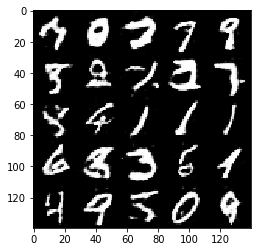

Epoch 2/2... Discriminator Loss: 0.484... Generator Loss: 2.947
Epoch 2/2... Discriminator Loss: 1.303... Generator Loss: 0.595
Epoch 2/2... Discriminator Loss: 0.586... Generator Loss: 1.774
Epoch 2/2... Discriminator Loss: 0.696... Generator Loss: 1.731
Epoch 2/2... Discriminator Loss: 1.395... Generator Loss: 0.532
Epoch 2/2... Discriminator Loss: 2.032... Generator Loss: 0.371
Epoch 2/2... Discriminator Loss: 0.920... Generator Loss: 1.014
Epoch 2/2... Discriminator Loss: 0.926... Generator Loss: 1.068
Epoch 2/2... Discriminator Loss: 0.616... Generator Loss: 1.876
Epoch 2/2... Discriminator Loss: 0.545... Generator Loss: 2.659


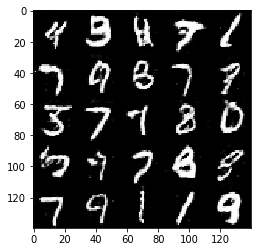

Epoch 2/2... Discriminator Loss: 0.657... Generator Loss: 1.785
Epoch 2/2... Discriminator Loss: 2.224... Generator Loss: 0.289
Epoch 2/2... Discriminator Loss: 0.615... Generator Loss: 1.642
Epoch 2/2... Discriminator Loss: 1.288... Generator Loss: 0.602
Epoch 2/2... Discriminator Loss: 1.179... Generator Loss: 0.922
Epoch 2/2... Discriminator Loss: 1.897... Generator Loss: 0.450
Epoch 2/2... Discriminator Loss: 0.400... Generator Loss: 3.153
Epoch 2/2... Discriminator Loss: 1.023... Generator Loss: 0.927
Epoch 2/2... Discriminator Loss: 0.574... Generator Loss: 2.098
Epoch 2/2... Discriminator Loss: 0.669... Generator Loss: 1.680


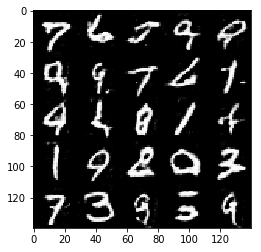

Epoch 2/2... Discriminator Loss: 1.382... Generator Loss: 0.658
Epoch 2/2... Discriminator Loss: 0.829... Generator Loss: 1.117
Epoch 2/2... Discriminator Loss: 1.209... Generator Loss: 0.617
Epoch 2/2... Discriminator Loss: 0.783... Generator Loss: 1.597
Epoch 2/2... Discriminator Loss: 0.664... Generator Loss: 1.632
Epoch 2/2... Discriminator Loss: 1.034... Generator Loss: 1.005
Epoch 2/2... Discriminator Loss: 0.857... Generator Loss: 1.411
Epoch 2/2... Discriminator Loss: 0.777... Generator Loss: 1.359
Epoch 2/2... Discriminator Loss: 0.601... Generator Loss: 1.675
Epoch 2/2... Discriminator Loss: 0.627... Generator Loss: 1.531


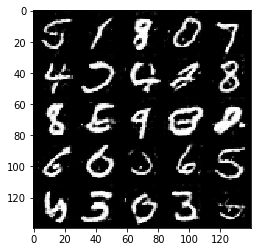

Epoch 2/2... Discriminator Loss: 0.431... Generator Loss: 2.806
Epoch 2/2... Discriminator Loss: 1.030... Generator Loss: 3.200
Epoch 2/2... Discriminator Loss: 0.500... Generator Loss: 2.634
Epoch 2/2... Discriminator Loss: 1.602... Generator Loss: 0.386
Epoch 2/2... Discriminator Loss: 0.653... Generator Loss: 1.594
Epoch 2/2... Discriminator Loss: 0.667... Generator Loss: 2.041
Epoch 2/2... Discriminator Loss: 2.457... Generator Loss: 0.159
Epoch 2/2... Discriminator Loss: 0.867... Generator Loss: 1.689
Epoch 2/2... Discriminator Loss: 0.898... Generator Loss: 1.137
Epoch 2/2... Discriminator Loss: 1.210... Generator Loss: 0.688


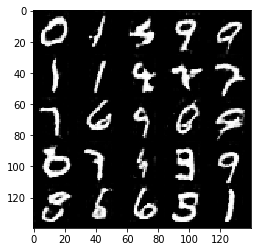

Epoch 2/2... Discriminator Loss: 0.772... Generator Loss: 1.364
Epoch 2/2... Discriminator Loss: 1.479... Generator Loss: 0.444
Epoch 2/2... Discriminator Loss: 0.749... Generator Loss: 1.402
Epoch 2/2... Discriminator Loss: 0.948... Generator Loss: 0.952
Epoch 2/2... Discriminator Loss: 0.771... Generator Loss: 1.262
Epoch 2/2... Discriminator Loss: 0.496... Generator Loss: 2.028
Epoch 2/2... Discriminator Loss: 1.037... Generator Loss: 0.953
Epoch 2/2... Discriminator Loss: 0.859... Generator Loss: 1.296
Epoch 2/2... Discriminator Loss: 0.457... Generator Loss: 3.020
Epoch 2/2... Discriminator Loss: 0.897... Generator Loss: 1.022


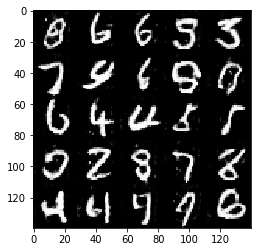

Epoch 2/2... Discriminator Loss: 1.509... Generator Loss: 0.548
Epoch 2/2... Discriminator Loss: 0.707... Generator Loss: 1.818
Epoch 2/2... Discriminator Loss: 0.845... Generator Loss: 1.077
Epoch 2/2... Discriminator Loss: 0.580... Generator Loss: 1.961
Epoch 2/2... Discriminator Loss: 1.264... Generator Loss: 0.772
Epoch 2/2... Discriminator Loss: 0.732... Generator Loss: 1.474
Epoch 2/2... Discriminator Loss: 2.226... Generator Loss: 0.239
Epoch 2/2... Discriminator Loss: 2.552... Generator Loss: 0.183
Epoch 2/2... Discriminator Loss: 1.099... Generator Loss: 0.859
Epoch 2/2... Discriminator Loss: 0.984... Generator Loss: 0.868


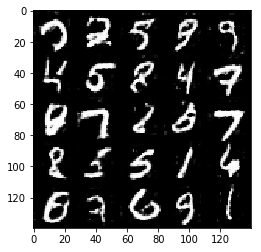

Epoch 2/2... Discriminator Loss: 0.692... Generator Loss: 2.107
Epoch 2/2... Discriminator Loss: 0.631... Generator Loss: 1.691
Epoch 2/2... Discriminator Loss: 0.660... Generator Loss: 1.628
Epoch 2/2... Discriminator Loss: 0.727... Generator Loss: 1.422
Epoch 2/2... Discriminator Loss: 1.422... Generator Loss: 0.543
Epoch 2/2... Discriminator Loss: 0.480... Generator Loss: 2.546
Epoch 2/2... Discriminator Loss: 0.806... Generator Loss: 1.635
Epoch 2/2... Discriminator Loss: 0.705... Generator Loss: 1.647
Epoch 2/2... Discriminator Loss: 0.479... Generator Loss: 2.837
Epoch 2/2... Discriminator Loss: 0.556... Generator Loss: 1.982


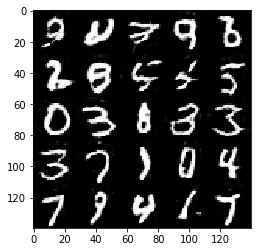

Epoch 2/2... Discriminator Loss: 0.920... Generator Loss: 1.194
Epoch 2/2... Discriminator Loss: 1.582... Generator Loss: 0.677
Epoch 2/2... Discriminator Loss: 0.511... Generator Loss: 2.264
Epoch 2/2... Discriminator Loss: 0.448... Generator Loss: 3.749
Epoch 2/2... Discriminator Loss: 1.309... Generator Loss: 0.743
Epoch 2/2... Discriminator Loss: 2.981... Generator Loss: 0.144
Epoch 2/2... Discriminator Loss: 1.031... Generator Loss: 1.002
Epoch 2/2... Discriminator Loss: 1.232... Generator Loss: 0.811
Epoch 2/2... Discriminator Loss: 0.720... Generator Loss: 1.436
Epoch 2/2... Discriminator Loss: 0.872... Generator Loss: 1.155


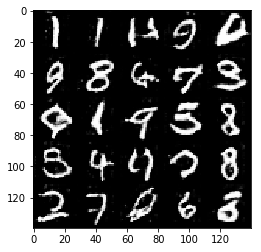

Epoch 2/2... Discriminator Loss: 1.516... Generator Loss: 0.778
Epoch 2/2... Discriminator Loss: 1.445... Generator Loss: 0.520
Epoch 2/2... Discriminator Loss: 0.590... Generator Loss: 2.273
Epoch 2/2... Discriminator Loss: 1.308... Generator Loss: 0.765
Epoch 2/2... Discriminator Loss: 0.685... Generator Loss: 2.838
Epoch 2/2... Discriminator Loss: 0.788... Generator Loss: 1.294
Epoch 2/2... Discriminator Loss: 0.700... Generator Loss: 1.929
Epoch 2/2... Discriminator Loss: 1.145... Generator Loss: 0.714
Epoch 2/2... Discriminator Loss: 1.102... Generator Loss: 0.822
Epoch 2/2... Discriminator Loss: 0.547... Generator Loss: 2.905


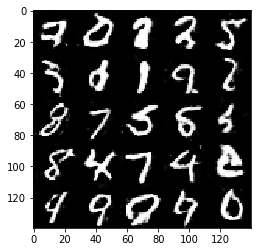

Epoch 2/2... Discriminator Loss: 0.810... Generator Loss: 1.096
Epoch 2/2... Discriminator Loss: 0.902... Generator Loss: 1.247
Epoch 2/2... Discriminator Loss: 0.916... Generator Loss: 1.102
Epoch 2/2... Discriminator Loss: 1.653... Generator Loss: 0.561
Epoch 2/2... Discriminator Loss: 0.625... Generator Loss: 1.796
Epoch 2/2... Discriminator Loss: 0.786... Generator Loss: 1.534
Epoch 2/2... Discriminator Loss: 0.654... Generator Loss: 1.593
Epoch 2/2... Discriminator Loss: 0.753... Generator Loss: 1.390
Epoch 2/2... Discriminator Loss: 0.745... Generator Loss: 1.269
Epoch 2/2... Discriminator Loss: 0.992... Generator Loss: 1.522


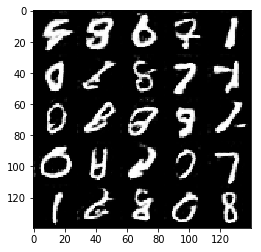

Epoch 2/2... Discriminator Loss: 0.826... Generator Loss: 1.269
Epoch 2/2... Discriminator Loss: 0.547... Generator Loss: 2.002
Epoch 2/2... Discriminator Loss: 0.537... Generator Loss: 1.900
Epoch 2/2... Discriminator Loss: 2.021... Generator Loss: 0.501
Epoch 2/2... Discriminator Loss: 0.557... Generator Loss: 1.841
Epoch 2/2... Discriminator Loss: 0.661... Generator Loss: 2.024
Epoch 2/2... Discriminator Loss: 0.997... Generator Loss: 0.894
Epoch 2/2... Discriminator Loss: 1.106... Generator Loss: 0.825
Epoch 2/2... Discriminator Loss: 0.909... Generator Loss: 1.029
Epoch 2/2... Discriminator Loss: 0.842... Generator Loss: 1.206


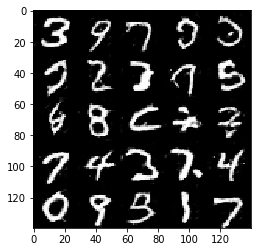

Epoch 2/2... Discriminator Loss: 0.794... Generator Loss: 1.179
Epoch 2/2... Discriminator Loss: 0.997... Generator Loss: 0.958
Epoch 2/2... Discriminator Loss: 0.474... Generator Loss: 3.445
Epoch 2/2... Discriminator Loss: 0.458... Generator Loss: 2.874
Epoch 2/2... Discriminator Loss: 0.426... Generator Loss: 3.096
Epoch 2/2... Discriminator Loss: 0.616... Generator Loss: 1.843
Epoch 2/2... Discriminator Loss: 0.362... Generator Loss: 4.076
Epoch 2/2... Discriminator Loss: 0.421... Generator Loss: 3.545
Epoch 2/2... Discriminator Loss: 0.905... Generator Loss: 1.165
Epoch 2/2... Discriminator Loss: 0.460... Generator Loss: 2.989


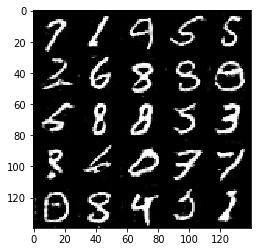

Epoch 2/2... Discriminator Loss: 0.537... Generator Loss: 2.357
Epoch 2/2... Discriminator Loss: 0.784... Generator Loss: 5.705
Epoch 2/2... Discriminator Loss: 0.665... Generator Loss: 1.690
Epoch 2/2... Discriminator Loss: 0.615... Generator Loss: 1.742
Epoch 2/2... Discriminator Loss: 1.347... Generator Loss: 0.951
Epoch 2/2... Discriminator Loss: 0.821... Generator Loss: 1.215
Epoch 2/2... Discriminator Loss: 1.180... Generator Loss: 0.641
Epoch 2/2... Discriminator Loss: 1.812... Generator Loss: 0.458
Epoch 2/2... Discriminator Loss: 0.576... Generator Loss: 1.873
Epoch 2/2... Discriminator Loss: 0.586... Generator Loss: 2.612


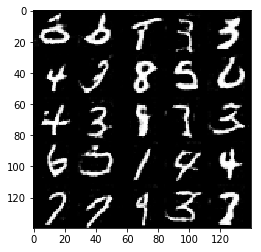

Epoch 2/2... Discriminator Loss: 0.589... Generator Loss: 2.179
Epoch 2/2... Discriminator Loss: 0.765... Generator Loss: 1.512
Epoch 2/2... Discriminator Loss: 1.396... Generator Loss: 0.551
Epoch 2/2... Discriminator Loss: 1.087... Generator Loss: 0.795
Epoch 2/2... Discriminator Loss: 0.944... Generator Loss: 1.119
Epoch 2/2... Discriminator Loss: 0.533... Generator Loss: 2.035
Epoch 2/2... Discriminator Loss: 1.389... Generator Loss: 3.290
Epoch 2/2... Discriminator Loss: 0.644... Generator Loss: 2.082
Epoch 2/2... Discriminator Loss: 1.078... Generator Loss: 0.941
Epoch 2/2... Discriminator Loss: 0.889... Generator Loss: 1.462


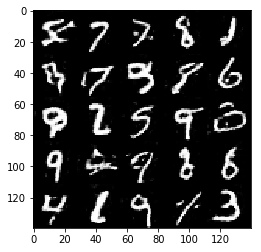

Epoch 2/2... Discriminator Loss: 0.872... Generator Loss: 1.024
Epoch 2/2... Discriminator Loss: 1.458... Generator Loss: 0.624
Epoch 2/2... Discriminator Loss: 0.924... Generator Loss: 1.038
Epoch 2/2... Discriminator Loss: 0.410... Generator Loss: 3.223
Epoch 2/2... Discriminator Loss: 2.480... Generator Loss: 0.157
Epoch 2/2... Discriminator Loss: 0.764... Generator Loss: 1.390
Epoch 2/2... Discriminator Loss: 0.815... Generator Loss: 1.399
Epoch 2/2... Discriminator Loss: 0.993... Generator Loss: 0.841
Epoch 2/2... Discriminator Loss: 1.322... Generator Loss: 0.904
Epoch 2/2... Discriminator Loss: 0.826... Generator Loss: 1.134


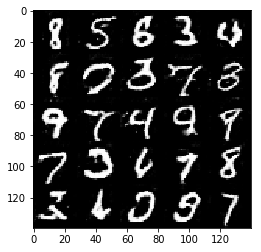

Epoch 2/2... Discriminator Loss: 0.725... Generator Loss: 1.899
Epoch 2/2... Discriminator Loss: 1.145... Generator Loss: 0.843
Epoch 2/2... Discriminator Loss: 0.663... Generator Loss: 1.699
Epoch 2/2... Discriminator Loss: 0.853... Generator Loss: 1.135
Epoch 2/2... Discriminator Loss: 1.317... Generator Loss: 0.846
Epoch 2/2... Discriminator Loss: 0.808... Generator Loss: 1.145
Epoch 2/2... Discriminator Loss: 0.455... Generator Loss: 2.701
Epoch 2/2... Discriminator Loss: 1.235... Generator Loss: 0.770
Epoch 2/2... Discriminator Loss: 0.506... Generator Loss: 2.731
Epoch 2/2... Discriminator Loss: 1.090... Generator Loss: 0.806


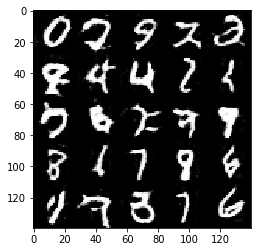

Epoch 2/2... Discriminator Loss: 0.735... Generator Loss: 1.571
Epoch 2/2... Discriminator Loss: 0.634... Generator Loss: 1.630
Epoch 2/2... Discriminator Loss: 0.758... Generator Loss: 1.334
Epoch 2/2... Discriminator Loss: 1.452... Generator Loss: 0.708
Epoch 2/2... Discriminator Loss: 2.324... Generator Loss: 0.282
Epoch 2/2... Discriminator Loss: 0.925... Generator Loss: 1.034
Epoch 2/2... Discriminator Loss: 0.530... Generator Loss: 2.960
Epoch 2/2... Discriminator Loss: 0.659... Generator Loss: 1.544
Epoch 2/2... Discriminator Loss: 0.825... Generator Loss: 1.297
Epoch 2/2... Discriminator Loss: 0.645... Generator Loss: 2.239


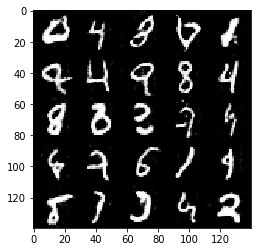

In [42]:
batch_size = 10
z_dim = 100
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.529... Generator Loss: 6.562
Epoch 1/1... Discriminator Loss: 1.883... Generator Loss: 25.746
Epoch 1/1... Discriminator Loss: 0.629... Generator Loss: 8.110
Epoch 1/1... Discriminator Loss: 0.736... Generator Loss: 1.786
Epoch 1/1... Discriminator Loss: 0.875... Generator Loss: 1.618
Epoch 1/1... Discriminator Loss: 1.233... Generator Loss: 0.791
Epoch 1/1... Discriminator Loss: 0.841... Generator Loss: 1.347
Epoch 1/1... Discriminator Loss: 1.499... Generator Loss: 4.881
Epoch 1/1... Discriminator Loss: 1.060... Generator Loss: 0.984
Epoch 1/1... Discriminator Loss: 1.509... Generator Loss: 5.095


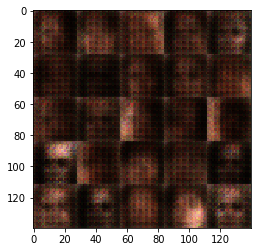

Epoch 1/1... Discriminator Loss: 0.715... Generator Loss: 1.685
Epoch 1/1... Discriminator Loss: 1.101... Generator Loss: 4.302
Epoch 1/1... Discriminator Loss: 0.799... Generator Loss: 1.374
Epoch 1/1... Discriminator Loss: 0.788... Generator Loss: 1.560
Epoch 1/1... Discriminator Loss: 1.027... Generator Loss: 0.966
Epoch 1/1... Discriminator Loss: 1.353... Generator Loss: 0.704
Epoch 1/1... Discriminator Loss: 0.859... Generator Loss: 1.347
Epoch 1/1... Discriminator Loss: 1.411... Generator Loss: 0.771
Epoch 1/1... Discriminator Loss: 0.930... Generator Loss: 2.464
Epoch 1/1... Discriminator Loss: 1.204... Generator Loss: 0.804


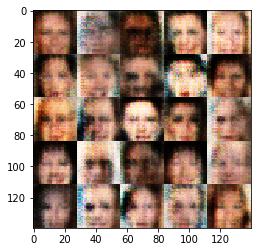

Epoch 1/1... Discriminator Loss: 1.041... Generator Loss: 2.531
Epoch 1/1... Discriminator Loss: 1.863... Generator Loss: 0.330
Epoch 1/1... Discriminator Loss: 1.044... Generator Loss: 1.266
Epoch 1/1... Discriminator Loss: 0.863... Generator Loss: 1.999
Epoch 1/1... Discriminator Loss: 1.824... Generator Loss: 3.188
Epoch 1/1... Discriminator Loss: 1.094... Generator Loss: 0.863
Epoch 1/1... Discriminator Loss: 1.034... Generator Loss: 0.982
Epoch 1/1... Discriminator Loss: 1.128... Generator Loss: 0.882
Epoch 1/1... Discriminator Loss: 0.715... Generator Loss: 2.197
Epoch 1/1... Discriminator Loss: 1.216... Generator Loss: 0.753


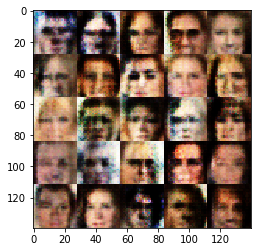

Epoch 1/1... Discriminator Loss: 1.042... Generator Loss: 1.020
Epoch 1/1... Discriminator Loss: 1.548... Generator Loss: 0.497
Epoch 1/1... Discriminator Loss: 1.412... Generator Loss: 0.535
Epoch 1/1... Discriminator Loss: 1.243... Generator Loss: 2.416
Epoch 1/1... Discriminator Loss: 1.380... Generator Loss: 1.865
Epoch 1/1... Discriminator Loss: 1.701... Generator Loss: 0.373
Epoch 1/1... Discriminator Loss: 0.997... Generator Loss: 1.155
Epoch 1/1... Discriminator Loss: 1.000... Generator Loss: 1.262
Epoch 1/1... Discriminator Loss: 1.047... Generator Loss: 1.025
Epoch 1/1... Discriminator Loss: 1.115... Generator Loss: 1.452


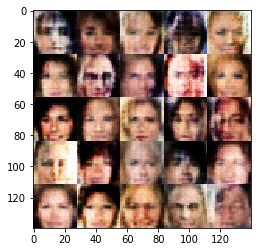

Epoch 1/1... Discriminator Loss: 1.353... Generator Loss: 0.593
Epoch 1/1... Discriminator Loss: 0.982... Generator Loss: 1.588
Epoch 1/1... Discriminator Loss: 1.653... Generator Loss: 0.420
Epoch 1/1... Discriminator Loss: 1.240... Generator Loss: 0.646
Epoch 1/1... Discriminator Loss: 0.992... Generator Loss: 1.019
Epoch 1/1... Discriminator Loss: 0.919... Generator Loss: 1.166
Epoch 1/1... Discriminator Loss: 0.953... Generator Loss: 1.061
Epoch 1/1... Discriminator Loss: 1.006... Generator Loss: 1.128
Epoch 1/1... Discriminator Loss: 1.061... Generator Loss: 1.940
Epoch 1/1... Discriminator Loss: 0.953... Generator Loss: 1.141


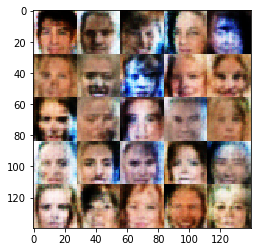

Epoch 1/1... Discriminator Loss: 0.976... Generator Loss: 1.526
Epoch 1/1... Discriminator Loss: 1.454... Generator Loss: 0.510
Epoch 1/1... Discriminator Loss: 0.908... Generator Loss: 1.501
Epoch 1/1... Discriminator Loss: 1.055... Generator Loss: 1.279
Epoch 1/1... Discriminator Loss: 1.000... Generator Loss: 1.683
Epoch 1/1... Discriminator Loss: 1.579... Generator Loss: 0.431
Epoch 1/1... Discriminator Loss: 1.309... Generator Loss: 2.739
Epoch 1/1... Discriminator Loss: 1.258... Generator Loss: 1.062
Epoch 1/1... Discriminator Loss: 1.541... Generator Loss: 0.470
Epoch 1/1... Discriminator Loss: 1.127... Generator Loss: 0.803


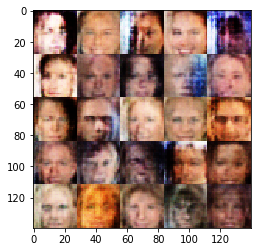

Epoch 1/1... Discriminator Loss: 1.070... Generator Loss: 1.020
Epoch 1/1... Discriminator Loss: 1.164... Generator Loss: 0.743
Epoch 1/1... Discriminator Loss: 0.961... Generator Loss: 1.071
Epoch 1/1... Discriminator Loss: 1.043... Generator Loss: 1.015
Epoch 1/1... Discriminator Loss: 1.249... Generator Loss: 0.729
Epoch 1/1... Discriminator Loss: 1.098... Generator Loss: 1.021
Epoch 1/1... Discriminator Loss: 0.977... Generator Loss: 1.087
Epoch 1/1... Discriminator Loss: 1.397... Generator Loss: 0.607
Epoch 1/1... Discriminator Loss: 1.254... Generator Loss: 0.711
Epoch 1/1... Discriminator Loss: 0.853... Generator Loss: 2.034


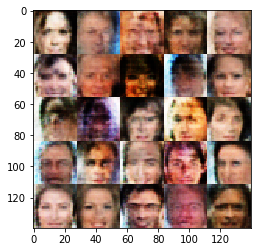

Epoch 1/1... Discriminator Loss: 1.265... Generator Loss: 0.726
Epoch 1/1... Discriminator Loss: 0.961... Generator Loss: 1.869
Epoch 1/1... Discriminator Loss: 1.070... Generator Loss: 2.186
Epoch 1/1... Discriminator Loss: 1.237... Generator Loss: 0.708
Epoch 1/1... Discriminator Loss: 0.944... Generator Loss: 1.104
Epoch 1/1... Discriminator Loss: 0.837... Generator Loss: 1.369
Epoch 1/1... Discriminator Loss: 1.160... Generator Loss: 0.791
Epoch 1/1... Discriminator Loss: 0.945... Generator Loss: 1.034
Epoch 1/1... Discriminator Loss: 1.311... Generator Loss: 0.693
Epoch 1/1... Discriminator Loss: 1.718... Generator Loss: 0.383


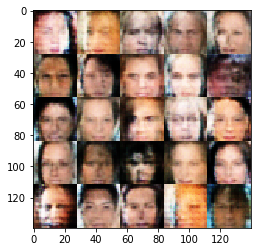

Epoch 1/1... Discriminator Loss: 1.798... Generator Loss: 2.820
Epoch 1/1... Discriminator Loss: 1.001... Generator Loss: 1.215
Epoch 1/1... Discriminator Loss: 1.160... Generator Loss: 0.799
Epoch 1/1... Discriminator Loss: 1.178... Generator Loss: 0.742
Epoch 1/1... Discriminator Loss: 1.366... Generator Loss: 0.517
Epoch 1/1... Discriminator Loss: 0.780... Generator Loss: 2.111
Epoch 1/1... Discriminator Loss: 1.270... Generator Loss: 0.658
Epoch 1/1... Discriminator Loss: 1.173... Generator Loss: 0.722
Epoch 1/1... Discriminator Loss: 1.052... Generator Loss: 1.038
Epoch 1/1... Discriminator Loss: 1.039... Generator Loss: 2.322


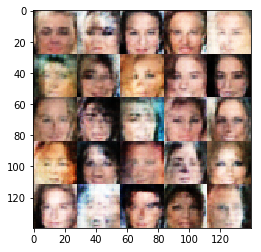

Epoch 1/1... Discriminator Loss: 1.230... Generator Loss: 0.738
Epoch 1/1... Discriminator Loss: 1.376... Generator Loss: 0.679
Epoch 1/1... Discriminator Loss: 0.916... Generator Loss: 1.075
Epoch 1/1... Discriminator Loss: 1.242... Generator Loss: 0.699
Epoch 1/1... Discriminator Loss: 1.314... Generator Loss: 1.716
Epoch 1/1... Discriminator Loss: 0.924... Generator Loss: 2.038
Epoch 1/1... Discriminator Loss: 1.138... Generator Loss: 0.832
Epoch 1/1... Discriminator Loss: 1.266... Generator Loss: 0.672
Epoch 1/1... Discriminator Loss: 0.901... Generator Loss: 1.191
Epoch 1/1... Discriminator Loss: 1.743... Generator Loss: 0.368


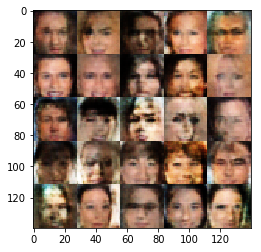

Epoch 1/1... Discriminator Loss: 1.290... Generator Loss: 2.201
Epoch 1/1... Discriminator Loss: 1.120... Generator Loss: 1.771
Epoch 1/1... Discriminator Loss: 1.070... Generator Loss: 0.911
Epoch 1/1... Discriminator Loss: 1.141... Generator Loss: 0.819
Epoch 1/1... Discriminator Loss: 1.228... Generator Loss: 0.722
Epoch 1/1... Discriminator Loss: 0.976... Generator Loss: 0.997
Epoch 1/1... Discriminator Loss: 0.868... Generator Loss: 1.474
Epoch 1/1... Discriminator Loss: 1.421... Generator Loss: 0.498
Epoch 1/1... Discriminator Loss: 1.184... Generator Loss: 1.852
Epoch 1/1... Discriminator Loss: 1.062... Generator Loss: 1.914


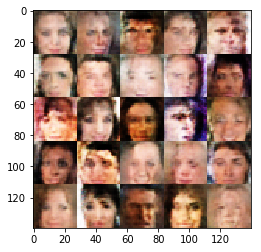

Epoch 1/1... Discriminator Loss: 0.793... Generator Loss: 1.758
Epoch 1/1... Discriminator Loss: 0.987... Generator Loss: 1.159
Epoch 1/1... Discriminator Loss: 1.294... Generator Loss: 1.877
Epoch 1/1... Discriminator Loss: 0.886... Generator Loss: 1.242
Epoch 1/1... Discriminator Loss: 0.921... Generator Loss: 1.552
Epoch 1/1... Discriminator Loss: 1.220... Generator Loss: 0.767
Epoch 1/1... Discriminator Loss: 1.079... Generator Loss: 0.830
Epoch 1/1... Discriminator Loss: 0.754... Generator Loss: 1.382
Epoch 1/1... Discriminator Loss: 1.360... Generator Loss: 0.689
Epoch 1/1... Discriminator Loss: 1.073... Generator Loss: 1.173


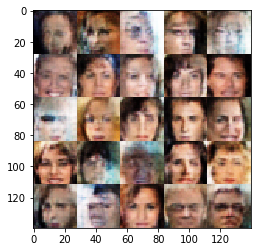

Epoch 1/1... Discriminator Loss: 1.007... Generator Loss: 1.117
Epoch 1/1... Discriminator Loss: 0.933... Generator Loss: 1.050
Epoch 1/1... Discriminator Loss: 0.989... Generator Loss: 1.460
Epoch 1/1... Discriminator Loss: 0.957... Generator Loss: 1.439
Epoch 1/1... Discriminator Loss: 1.041... Generator Loss: 0.885
Epoch 1/1... Discriminator Loss: 0.996... Generator Loss: 1.491
Epoch 1/1... Discriminator Loss: 1.932... Generator Loss: 0.316
Epoch 1/1... Discriminator Loss: 0.680... Generator Loss: 2.314
Epoch 1/1... Discriminator Loss: 0.899... Generator Loss: 1.393
Epoch 1/1... Discriminator Loss: 0.929... Generator Loss: 1.313


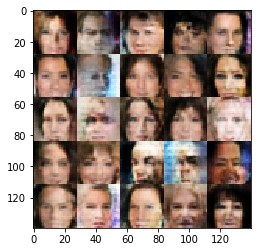

Epoch 1/1... Discriminator Loss: 0.896... Generator Loss: 1.856
Epoch 1/1... Discriminator Loss: 1.128... Generator Loss: 0.788
Epoch 1/1... Discriminator Loss: 0.894... Generator Loss: 1.470
Epoch 1/1... Discriminator Loss: 0.847... Generator Loss: 1.514
Epoch 1/1... Discriminator Loss: 0.795... Generator Loss: 1.375
Epoch 1/1... Discriminator Loss: 1.123... Generator Loss: 0.805
Epoch 1/1... Discriminator Loss: 0.884... Generator Loss: 1.442
Epoch 1/1... Discriminator Loss: 0.905... Generator Loss: 1.984
Epoch 1/1... Discriminator Loss: 0.953... Generator Loss: 1.089
Epoch 1/1... Discriminator Loss: 0.814... Generator Loss: 1.277


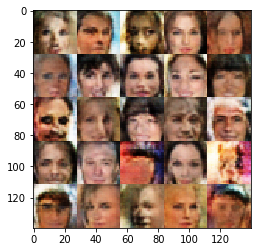

Epoch 1/1... Discriminator Loss: 0.955... Generator Loss: 1.013
Epoch 1/1... Discriminator Loss: 0.901... Generator Loss: 1.355
Epoch 1/1... Discriminator Loss: 1.064... Generator Loss: 1.554
Epoch 1/1... Discriminator Loss: 1.575... Generator Loss: 0.476
Epoch 1/1... Discriminator Loss: 1.075... Generator Loss: 0.922
Epoch 1/1... Discriminator Loss: 1.348... Generator Loss: 2.505
Epoch 1/1... Discriminator Loss: 1.136... Generator Loss: 1.587
Epoch 1/1... Discriminator Loss: 0.791... Generator Loss: 1.637
Epoch 1/1... Discriminator Loss: 0.840... Generator Loss: 1.406
Epoch 1/1... Discriminator Loss: 1.021... Generator Loss: 0.838


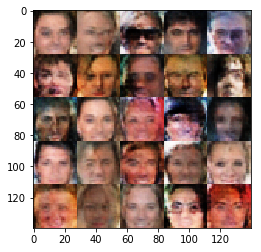

Epoch 1/1... Discriminator Loss: 1.058... Generator Loss: 0.923
Epoch 1/1... Discriminator Loss: 0.874... Generator Loss: 1.085
Epoch 1/1... Discriminator Loss: 1.171... Generator Loss: 2.279
Epoch 1/1... Discriminator Loss: 0.947... Generator Loss: 1.482
Epoch 1/1... Discriminator Loss: 0.809... Generator Loss: 1.681
Epoch 1/1... Discriminator Loss: 0.940... Generator Loss: 1.314
Epoch 1/1... Discriminator Loss: 0.957... Generator Loss: 1.021
Epoch 1/1... Discriminator Loss: 0.976... Generator Loss: 0.919


In [43]:
batch_size = 64
z_dim = 100
learning_rate = .0002
beta1 = .55


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.